In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import fftpack, signal 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cv2
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
def get_data(path=""):
    data_ls = os.listdir(path)
    data_set = []
    for data in range(len(data_ls)):
        try:
            ds = pd.read_csv(path + "/" + data_ls[data], header=None)
            ds = ds.rename(columns={0: 'Tachometer', 1: 'UA axial', 2: 'UA radial', 3: 'UA tangential', 4: 'OA axial', 5: 'OA radial', 6: 'OA tangential', 7: 'Microphone'})
            data_set.append(ds)
        except:
            pass
    return data_set


def get_means(data_set):
    means = []
    for i in range(len(data_set)):
        mean = data_set[i].mean(axis = 0)
        means.append(mean)
    
    means = pd.DataFrame(means)
    return means

def get_stds(data_set):
    stds = []
    for i in range(len(data_set)):
        std = data_set[i].std(axis = 0)
        stds.append(std)
    
    stds = pd.DataFrame(stds)    
    return stds


def plot_all_features(data_set):
    plt.figure(figsize=(20, 15))

    #Tachometer works with ttl signal
    plt.subplot(4, 2, 1)
    plt.plot(data_set["Tachometer"], color="blue")
    plt.title("Tachometer graph")
    plt.ylabel('V')

    #All acelerometers works with 10.2 mV/(m/s²) sensitivity 
    plt.subplot(4, 2, 2)
    plt.plot(data_set["UA axial"], color='green')
    plt.title("Underhang axial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 3)
    plt.plot(data_set["UA radial"], color="black")
    plt.title("Underhang radial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 4)
    plt.plot(data_set["UA tangential"], color='orange')
    plt.title("Underhang tangential graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 5)
    plt.plot(data_set["OA axial"], color="pink")
    plt.title("Overhang axial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 6)
    plt.plot(data_set["OA radial"], color='yellow')
    plt.title("Overhang radial graph")
    plt.ylabel('mV')

    plt.subplot(4, 2, 7)
    plt.plot(data_set["OA tangential"], color="brown")
    plt.title("Overhang tangential graph")
    plt.xlabel('experiments')
    plt.ylabel('mV')

    #Microphone works with dB
    plt.subplot(4, 2, 8)
    plt.plot(data_set["Microphone"], color='gray')
    plt.title("Microphone graph")
    plt.xlabel('experiments')
    plt.ylabel('DB')


def down_sampler(data_set, initial_sample, sample_interval):
    first_sample = initial_sample
    final_sample = sample_interval
    data_decreased = []
    
    for i in range(len(data_set)):
        first_sample = initial_sample
        final_sample = sample_interval
        
        for j in range(int(len(data_set[0])/sample_interval)):
            data = data_set[i][first_sample:final_sample].mean()
            data_decreased.append(data)
        
            first_sample = first_sample + sample_interval
            final_sample = final_sample + sample_interval
            
    data_decreased = pd.DataFrame(data_decreased)  
    return data_decreased

#numpy also has fft but scipy is most efficient
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html
def FFT(data_set):
    autocorr = signal.fftconvolve(data_set, data_set[::-1], mode='full')
    autocorr = pd.DataFrame(autocorr)
    return autocorr

def rolling_rows(data, roll):
    data = np.array(data)
    roll_data = []
    
    for i in range(len(data)):
        roll_data.append(data[i-roll])

    return pd.DataFrame(roll_data)

# Getting Data

In [3]:
normal_data = get_data("data/normal")

In [ ]:
imbalance_6 = get_data("data/imbalance/6g")
imbalance_10 = get_data("data/imbalance/10g")
imbalance_15 = get_data("data/imbalance/15g")
imbalance_20 = get_data("data/imbalance/20g")
imbalance_25 = get_data("data/imbalance/25g")
imbalance_30 = get_data("data/imbalance/30g")
imbalance_35 = get_data("data/imbalance/35g")

imbalance_keys = ["imbalance_6", "imbalance_10", "imbalance_15", "imbalance_20", "imbalance_25", "imbalance_30", "imbalance_35"]
imbalance_data = {"imbalance_6": imbalance_6,
                  "imbalance_10": imbalance_10,
                  "imbalance_15": imbalance_15, 
                  "imbalance_20": imbalance_20, 
                  "imbalance_25": imbalance_25, 
                  "imbalance_30": imbalance_30, 
                  "imbalance_35": imbalance_35}

In [ ]:
horizontal_data_0_5mm =  get_data("data/horizontal-misalignment/0.5mm")
horizontal_data_1_0mm =  get_data("data/horizontal-misalignment/1.0mm")
horizontal_data_1_5mm =  get_data("data/horizontal-misalignment/1.5mm")
horizontal_data_2_0mm =  get_data("data/horizontal-misalignment/2.0mm")

horizontal_keys = ["horizontal_data_0_5mm", "horizontal_data_1_0mm", "horizontal_data_1_5mm", "horizontal_data_2_0mm"]
horizontal_data = {"horizontal_data_0_5mm": horizontal_data_0_5mm,
                   "horizontal_data_1_0mm": horizontal_data_1_0mm,
                   "horizontal_data_1_5mm": horizontal_data_1_5mm,
                   "horizontal_data_2_0mm": horizontal_data_2_0mm}

In [ ]:
vertical_data_0_51 = get_data("data/vertical-misalignment/0.51mm")
vertical_data_0_63 = get_data("data/vertical-misalignment/0.63mm")
vertical_data_1_27 = get_data("data/vertical-misalignment/1.27mm")
vertical_data_1_40 = get_data("data/vertical-misalignment/1.40mm")
vertical_data_1_78 = get_data("data/vertical-misalignment/1.78mm")
vertical_data_1_90 = get_data("data/vertical-misalignment/1.90mm")

vertical_keys = ["vertical_data_0_51", "vertical_data_0_63", "vertical_data_1_27", "vertical_data_1_40", "vertical_data_1_78", "vertical_data_1_90"]
vertical_data = {"vertical_data_0_51": vertical_data_0_51,
                 "vertical_data_0_63": vertical_data_0_63,
                 "vertical_data_1_27": vertical_data_1_27,
                 "vertical_data_1_40": vertical_data_1_40,
                 "vertical_data_1_78": vertical_data_1_78,
                 "vertical_data_1_90": vertical_data_1_90}

In [ ]:
overhang_data_ball_0g = get_data("data/overhang/ball_fault/0g")
overhang_data_ball_6g = get_data("data/overhang/ball_fault/6g")
overhang_data_ball_20g = get_data("data/overhang/ball_fault/20g")
overhang_data_ball_35g = get_data("data/overhang/ball_fault/35g")

overhang_data_cage_0g = get_data("data/overhang/ball_fault/0g")
overhang_data_cage_6g = get_data("data/overhang/ball_fault/6g")
overhang_data_cage_20g = get_data("data/overhang/ball_fault/20g")
overhang_data_cage_35g = get_data("data/overhang/ball_fault/35g")

overhang_data_outerRace_0g = get_data("data/overhang/ball_fault/0g")
overhang_data_outerRace_6g = get_data("data/overhang/ball_fault/6g")
overhang_data_outerRace_20g = get_data("data/overhang/ball_fault/20g")
overhang_data_outerRace_35g = get_data("data/overhang/ball_fault/35g")


overhang_keys = ["overhang_data_ball_0g", "overhang_data_ball_6g", "overhang_data_ball_20g", "overhang_data_ball_35g", "overhang_data_cage_0g", "overhang_data_cage_6g", "overhang_data_cage_20g", "overhang_data_cage_35g", "overhang_data_outerRace_0g", "overhang_data_outerRace_6g", "overhang_data_outerRace_20g", "overhang_data_outerRace_35g"]
overhang_data = {"overhang_data_ball_0g": overhang_data_ball_0g, 
                "overhang_data_ball_6g": overhang_data_ball_6g, 
                "overhang_data_ball_20g": overhang_data_ball_20g, 
                "overhang_data_ball_35g": overhang_data_ball_35g, 
                "overhang_data_cage_0g": overhang_data_cage_0g, 
                "overhang_data_cage_6g": overhang_data_cage_6g, 
                "overhang_data_cage_20g": overhang_data_cage_20g, 
                "overhang_data_cage_35g": overhang_data_cage_35g, 
                "overhang_data_outerRace_0g": overhang_data_outerRace_0g, 
                "overhang_data_outerRace_6g": overhang_data_outerRace_6g, 
                "overhang_data_outerRace_20g": overhang_data_outerRace_20g, 
                "overhang_data_outerRace_35g": overhang_data_outerRace_35g}

In [ ]:
underhang_data_ball_0g = get_data("data/underhang/ball_fault/0g")
underhang_data_ball_6g = get_data("data/underhang/ball_fault/6g")
underhang_data_ball_20g = get_data("data/underhang/ball_fault/20g")
underhang_data_ball_35g = get_data("data/underhang/ball_fault/35g")

underhang_data_cage_0g = get_data("data/underhang/ball_fault/0g")
underhang_data_cage_6g = get_data("data/underhang/ball_fault/6g")
underhang_data_cage_20g = get_data("data/underhang/ball_fault/20g")
underhang_data_cage_35g = get_data("data/underhang/ball_fault/35g")

underhang_data_outerRace_0g = get_data("data/underhang/ball_fault/0g")
underhang_data_outerRace_6g = get_data("data/underhang/ball_fault/6g")
underhang_data_outerRace_20g = get_data("data/underhang/ball_fault/20g")
underhang_data_outerRace_35g = get_data("data/underhang/ball_fault/35g")


underhang_keys = ["underhang_data_ball_0g", "underhang_data_ball_6g", "underhang_data_ball_20g", "underhang_data_ball_35g", "underhang_data_cage_0g", "underhang_data_cage_6g", "underhang_data_cage_20g", "underhang_data_cage_35g", "underhang_data_outerRace_0g", "underhang_data_outerRace_6g", "underhang_data_outerRace_20g", "underhang_data_outerRace_35g"]
underhang_data = {"underhang_data_ball_0g": underhang_data_ball_0g, 
                  "underhang_data_ball_6g": underhang_data_ball_6g, 
                  "underhang_data_ball_20g": underhang_data_ball_20g, 
                  "underhang_data_ball_35g": underhang_data_ball_35g, 
                  "underhang_data_cage_0g": underhang_data_cage_0g, 
                  "underhang_data_cage_6g": underhang_data_cage_6g, 
                  "underhang_data_cage_20g": underhang_data_cage_20g, 
                  "underhang_data_cage_35g": underhang_data_cage_35g, 
                  "underhang_data_outerRace_0g": underhang_data_outerRace_0g, 
                  "underhang_data_outerRace_6g": underhang_data_outerRace_6g, 
                  "underhang_data_outerRace_20g": underhang_data_outerRace_20g, 
                  "underhang_data_outerRace_35g" :underhang_data_outerRace_35g}

In [ ]:
#shapes

print("Normal data")
print(len(normal_data))
print("--------------------------")

print("Imbalance data")
for i in range(len(imbalance_keys)):
    print(i, len(imbalance_data[imbalance_keys[i]]))    
print("--------------------------")

print("Horizontal data")
for i in range(len(horizontal_keys)):
    print(i, len(horizontal_data[horizontal_keys[i]]))
print("--------------------------")

print("Vertical data")
for i in range(len(vertical_keys)):
    print(i, len(vertical_data[vertical_keys[i]]))
print("--------------------------")

print("Overhang data")
for i in range(len(overhang_keys)):
    print(i, len(overhang_data[overhang_keys[i]]))
print("--------------------------")

print("Underhang data")
for i in range(len(underhang_keys)):
    print(i, len(underhang_data[underhang_keys[i]]))
print("--------------------------")

# Reducing Data

In [ ]:
normal_data = down_sampler(normal_data, 0, 5000)

In [ ]:
for i in range(len(imbalance_keys)):
    imbalance_data[imbalance_keys[i]] = down_sampler(imbalance_data[imbalance_keys[i]], 0, 5000)

In [ ]:
for i in range(len(horizontal_keys)):
    horizontal_data[horizontal_keys[i]] = down_sampler(horizontal_data[horizontal_keys[i]], 0, 5000)

In [ ]:
for i in range(len(vertical_keys)):
    vertical_data[vertical_keys[i]] = down_sampler(vertical_data[vertical_keys[i]], 0, 5000)

In [ ]:
for i in range(len(overhang_keys)):
    overhang_data[overhang_keys[i]] = down_sampler(overhang_data[overhang_keys[i]], 0, 5000)

In [ ]:
for i in range(len(underhang_keys)):
    underhang_data[underhang_keys[i]] = down_sampler(underhang_data[underhang_keys[i]], 0, 5000)

In [ ]:
imbalance_data[imbalance_keys[0]]

In [ ]:
#Saving reduced data to use in Mafaulda_app

normal_data.to_csv('Mafaulda_app/reduced_data/reduced_normal_data.csv',index=False)

for i in range(len(imbalance_data)):
    path = 'Mafaulda_app/reduced_data/reduced_' + imbalance_keys[i] + '.csv'
    imbalance_data[imbalance_keys[i]].to_csv(path ,index=False)

for i in range(len(horizontal_data)):
    path = 'Mafaulda_app/reduced_data/reduced_' + horizontal_keys[i] + '.csv'
    horizontal_data[horizontal_keys[i]].to_csv(path ,index=False)
    
for i in range(len(vertical_data)):
    path = 'Mafaulda_app/reduced_data/reduced_' + vertical_keys[i] + '.csv'
    vertical_data[vertical_keys[i]].to_csv(path ,index=False)
    
for i in range(len(overhang_data)):
    path = 'Mafaulda_app/reduced_data/reduced_' + overhang_keys[i] + '.csv'
    overhang_data[overhang_keys[i]].to_csv(path ,index=False)
    
for i in range(len(underhang_data)):
    path = 'Mafaulda_app/reduced_data/reduced_' + underhang_keys[i] + '.csv'
    underhang_data[underhang_keys[i]].to_csv(path ,index=False)

In [ ]:
plot_all_features(underhang_data[underhang_keys[10]])

# Classify Fault Type

In [19]:
# applying FFT and normalizing data

imbalance_shape = len(normal_data) / 7
horizontal_shape = len(normal_data) / 4 
vertical_shape = len(normal_data) / 6
overhang_shape = len(normal_data) / 12
underhang_shape = len(normal_data) / 12

normal_data_n = FFT(normal_data)

imbalance_6_n = FFT(imbalance_data[imbalance_keys[0]][:int(imbalance_shape)])
imbalance_10_n = FFT(imbalance_data[imbalance_keys[1]][int(imbalance_shape):2*int(imbalance_shape)])
imbalance_15_n = FFT(imbalance_data[imbalance_keys[2]][2*int(imbalance_shape):3*int(imbalance_shape)])
imbalance_20_n = FFT(imbalance_data[imbalance_keys[3]][3*int(imbalance_shape):4*int(imbalance_shape)])
imbalance_25_n = FFT(imbalance_data[imbalance_keys[4]][4*int(imbalance_shape):5*int(imbalance_shape)])
imbalance_30_n = FFT(imbalance_data[imbalance_keys[5]][5*int(imbalance_shape):6*int(imbalance_shape)])
imbalance_35_n = FFT(imbalance_data[imbalance_keys[6]][6*int(imbalance_shape):7*int(imbalance_shape)])

horizontal_data_0_5mm_n = FFT(horizontal_data[horizontal_keys[0]][:int(horizontal_shape)])
horizontal_data_1_0mm_n = FFT(horizontal_data[horizontal_keys[1]][int(horizontal_shape):2*int(horizontal_shape)])
horizontal_data_1_5mm_n = FFT(horizontal_data[horizontal_keys[2]][2*int(horizontal_shape):3*int(horizontal_shape)])
horizontal_data_2_0mm_n = FFT(horizontal_data[horizontal_keys[3]][3*int(horizontal_shape):4*int(horizontal_shape)])

vertical_data_0_51_n = FFT(vertical_data[vertical_keys[0]][:int(vertical_shape)])
vertical_data_0_63_n = FFT(vertical_data[vertical_keys[1]][int(vertical_shape):2*int(vertical_shape)])
vertical_data_1_27_n = FFT(vertical_data[vertical_keys[2]][2*int(vertical_shape):3*int(vertical_shape)])
vertical_data_1_40_n = FFT(vertical_data[vertical_keys[3]][3*int(vertical_shape):4*int(vertical_shape)])
vertical_data_1_78_n = FFT(vertical_data[vertical_keys[4]][4*int(vertical_shape):5*int(vertical_shape)])
vertical_data_1_90_n = FFT(vertical_data[vertical_keys[5]][5*int(vertical_shape):6*int(vertical_shape)])

overhang_data_ball_0g_n = FFT(overhang_data[overhang_keys[0]][:int(overhang_shape)])
overhang_data_ball_6g_n = FFT(overhang_data[overhang_keys[1]][int(overhang_shape):2*int(overhang_shape)])
overhang_data_ball_20g_n = FFT(overhang_data[overhang_keys[2]][2*int(overhang_shape):3*int(overhang_shape)])
overhang_data_ball_35g_n = FFT(overhang_data[overhang_keys[3]][3*int(overhang_shape):4*int(overhang_shape)])
overhang_data_cage_0g_n = FFT(overhang_data[overhang_keys[4]][4*int(overhang_shape):5*int(overhang_shape)])
overhang_data_cage_6g_n = FFT(overhang_data[overhang_keys[5]][5*int(overhang_shape):6*int(overhang_shape)])
overhang_data_cage_20g_n = FFT(overhang_data[overhang_keys[6]][6*int(overhang_shape):7*int(overhang_shape)])
overhang_data_cage_35g_n = FFT(overhang_data[overhang_keys[7]][7*int(overhang_shape):8*int(overhang_shape)])
overhang_data_outerRace_0g_n = FFT(overhang_data[overhang_keys[8]][8*int(overhang_shape):9*int(overhang_shape)])
overhang_data_outerRace_6g_n = FFT(overhang_data[overhang_keys[9]][9*int(overhang_shape):10*int(overhang_shape)])
overhang_data_outerRace_20g_n = FFT(overhang_data[overhang_keys[10]][10*int(overhang_shape):11*int(overhang_shape)])
overhang_data_outerRace_35g_n = FFT(overhang_data[overhang_keys[11]][11*int(overhang_shape):12*int(overhang_shape)])

underhang_data_ball_0g_n = FFT(underhang_data[underhang_keys[0]][:int(underhang_shape)])
underhang_data_ball_6g_n = FFT(underhang_data[underhang_keys[1]][int(underhang_shape):2*int(underhang_shape)])
underhang_data_ball_20g_n = FFT(underhang_data[underhang_keys[2]][2*int(underhang_shape):3*int(underhang_shape)])
underhang_data_ball_35g_n = FFT(underhang_data[underhang_keys[3]][3*int(underhang_shape):4*int(underhang_shape)])
underhang_data_cage_0g_n = FFT(underhang_data[underhang_keys[4]][4*int(underhang_shape):5*int(underhang_shape)])
underhang_data_cage_6g_n = FFT(underhang_data[underhang_keys[5]][5*int(underhang_shape):6*int(underhang_shape)])
underhang_data_cage_20g_n = FFT(underhang_data[underhang_keys[6]][6*int(underhang_shape):7*int(underhang_shape)])
underhang_data_cage_35g_n = FFT(underhang_data[underhang_keys[7]][7*int(underhang_shape):8*int(underhang_shape)])
underhang_data_outerRace_0g_n = FFT(underhang_data[underhang_keys[8]][8*int(underhang_shape):9*int(underhang_shape)])
underhang_data_outerRace_6g_n = FFT(underhang_data[underhang_keys[9]][9*int(underhang_shape):10*int(underhang_shape)])
underhang_data_outerRace_20g_n = FFT(underhang_data[underhang_keys[10]][10*int(underhang_shape):11*int(underhang_shape)])
underhang_data_outerRace_35g_n = FFT(underhang_data[underhang_keys[11]][11*int(underhang_shape):12*int(underhang_shape)])



imbalance_data_n = pd.concat([imbalance_6_n, imbalance_10_n, imbalance_15_n, imbalance_20_n, imbalance_25_n, imbalance_30_n, imbalance_35_n], ignore_index=True)
horizontal_data_n = pd.concat([horizontal_data_0_5mm_n, horizontal_data_1_0mm_n, horizontal_data_1_5mm_n, horizontal_data_2_0mm_n], ignore_index=True)
vertical_data_n = pd.concat([vertical_data_0_51_n, vertical_data_0_63_n, vertical_data_1_27_n, vertical_data_1_40_n, vertical_data_1_78_n, vertical_data_1_90_n], ignore_index=True)
overhang_data_n = pd.concat([overhang_data_ball_0g_n, overhang_data_ball_6g_n, overhang_data_ball_20g_n, overhang_data_ball_35g_n, overhang_data_cage_0g_n, overhang_data_cage_6g_n, overhang_data_cage_20g_n, overhang_data_cage_35g_n, overhang_data_outerRace_0g_n, overhang_data_outerRace_6g_n, overhang_data_outerRace_20g_n, overhang_data_outerRace_35g_n], ignore_index=True)
underhang_data_n = pd.concat([underhang_data_ball_0g_n, underhang_data_ball_6g_n, underhang_data_ball_20g_n, underhang_data_ball_35g_n, underhang_data_cage_0g_n, underhang_data_cage_6g_n, underhang_data_cage_20g_n, underhang_data_cage_35g_n, underhang_data_outerRace_0g_n, underhang_data_outerRace_6g_n, underhang_data_outerRace_20g_n, underhang_data_outerRace_35g_n], ignore_index=True)

In [22]:
normal_data_n.to_csv("Mafaulda_app/reduced_data/reduced_data_n.csv" ,index=False)
imbalance_data_n.to_csv("Mafaulda_app/reduced_data/reduced_imbalance_data_n.csv" ,index=False)
horizontal_data_n.to_csv("Mafaulda_app/reduced_data/reduced_horizontal_data_n.csv" ,index=False)
vertical_data_n.to_csv("Mafaulda_app/reduced_data/reduced_vertical_data_n.csv" ,index=False)
overhang_data_n.to_csv("Mafaulda_app/reduced_data/reduced_overhang_data_n.csv" ,index=False)
underhang_data_n.to_csv("Mafaulda_app/reduced_data/reduced_underhang_data_n.csv" ,index=False)

In [19]:
# normal_data_n
# imbalance_data_n
# horizontal_n
# vertical_data_n
# overhang_data_n
# underhang_data_n

In [23]:
data_fault = pd.concat([normal_data_n, imbalance_data_n, horizontal_data_n, vertical_data_n, overhang_data_n, underhang_data_n], ignore_index=True)
data_fault

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.000983,-0.000394,-0.000462,-0.000130,-0.031095,-0.002707,-0.011456,0.001349,0.211282,0.040030,0.606781,0.041804,0.294650,0.012991,0.000143
1,-0.000204,-0.000241,0.000018,-0.000055,-0.107068,0.003149,-0.101306,0.000850,0.291999,0.058014,0.247082,0.062128,0.098447,0.016532,0.000297
2,0.007892,0.000677,0.001447,-0.000123,-0.088640,0.001892,-0.112204,-0.008599,0.036063,0.013018,-1.011155,0.033442,-0.644437,0.008699,0.000456
3,0.008661,0.001586,0.000171,0.000126,0.032657,0.003640,0.079681,-0.007618,-0.501086,-0.085520,-2.134151,-0.049425,-1.320960,-0.010317,0.000597
4,-0.001524,0.002180,-0.000094,-0.000462,0.102618,-0.015845,0.171723,0.007179,-0.564611,-0.100138,-1.002434,-0.068172,-0.754281,-0.019373,0.000750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26953,0.043821,-0.003449,-0.004390,-0.001325,-0.047456,0.000257,0.010404,-0.006232,-0.014622,0.004038,-0.030808,0.008114,0.020261,0.000923,0.000612
26954,-0.038152,0.005287,0.008346,0.003588,0.039609,0.009638,-0.023125,0.005974,0.074408,0.009661,0.063392,0.003639,-0.009951,0.000322,0.000480
26955,0.010399,0.004104,-0.011007,-0.005634,0.015123,0.005387,-0.001204,-0.007803,-0.051487,-0.010554,-0.051689,0.003402,-0.009912,0.002651,0.000372
26956,0.010290,-0.001123,0.000850,-0.004180,-0.037674,-0.001086,-0.021248,0.001559,0.035289,0.004975,0.028362,0.002363,0.003339,-0.000618,0.000244


In [24]:
y_normal = pd.DataFrame(np.zeros(len(normal_data_n), dtype=int))
y_imbalance = pd.DataFrame(np.ones(len(imbalance_data_n), dtype=int))
y_horizontal_data = pd.DataFrame(np.full(len(horizontal_data_n), 2, dtype=int)) 
y_vertical_data = pd.DataFrame(np.full(len(vertical_data_n), 3, dtype=int))
y_overhang_data = pd.DataFrame(np.full(len(overhang_data_n), 4, dtype=int))
y_underhang_data = pd.DataFrame(np.full(len(underhang_data_n), 5, dtype=int))

y_total = pd.concat([y_normal, y_imbalance, y_horizontal_data, y_vertical_data, y_overhang_data, y_underhang_data], ignore_index=True)
y_total

,0
0,0
1,0
2,0
3,0
4,0
...,...
26953,5
26954,5
26955,5
26956,5


In [25]:
X_train_fault, X_test_fault, y_train_fault, y_test_fault = train_test_split(data_fault, y_total, test_size=0.25, shuffle=True)

In [27]:
fault_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation="relu", input_shape=(15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [28]:
fault_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
fault_model.fit(X_train_fault, y_train_fault, epochs=5)

Epoch 1/5


2022-10-12 20:35:49.200725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


632/632 [==============================] - 5s 5ms/step - loss: 0.9125 - accuracy: 0.6602
Epoch 2/5
632/632 [==============================] - 3s 5ms/step - loss: 0.5978 - accuracy: 0.7781
Epoch 3/5
632/632 [==============================] - 3s 5ms/step - loss: 0.4877 - accuracy: 0.8171
Epoch 4/5
632/632 [==============================] - 3s 5ms/step - loss: 0.4372 - accuracy: 0.8414
Epoch 5/5
632/632 [==============================] - 3s 5ms/step - loss: 0.3904 - accuracy: 0.8558


In [30]:
def classify_fault(x, y, index):
    responses = {0:'normal', 1:'imbalance', 2:'horizontal', 3:'vertical', 4:'overhang', 5:'underhang'}
    predicts = fault_model.predict(x)
    predict = responses[np.argmax(predicts[index], axis=0)]
    
    real_status = responses[int(y[0][index:index+1])]
    
    print("Status predicted: " + predict)
    print("Real Status: " + real_status)
    
def classify_fault_dois(x, y, index):
    responses = {0:'normal', 1:'imbalance', 2:'horizontal', 3:'vertical', 4:'overhang', 5:'underhang'}
    predicts = fault_model.predict(x)
    predict = responses[np.argmax(predicts, axis=0)]
    
    real_status = responses[int(y[0][index:index+1])]
    
    print("Status predicted: " + predict)
    print("Real Status: " + real_status)

In [31]:
classify_fault(X_test_fault, y_test_fault, 50)

Status predicted: normal
Real Status: normal


In [28]:
classify_fault(imbalance_6_n, y_test_fault, 5)

Status predicted: imbalance
Real Status: imbalance


In [32]:
fault_model.save('Mafaulda_app/models/fault_model.h5')

# Classify Imbalance

In [37]:
imbalance_6_FFT = FFT(imbalance_data[imbalance_keys[0]])
imbalance_10_FFT = FFT(imbalance_data[imbalance_keys[1]])
imbalance_15_FFT = FFT(imbalance_data[imbalance_keys[2]])
imbalance_20_FFT = FFT(imbalance_data[imbalance_keys[3]])
imbalance_25_FFT = FFT(imbalance_data[imbalance_keys[4]])
imbalance_30_FFT = FFT(imbalance_data[imbalance_keys[5]])
imbalance_35_FFT = FFT(imbalance_data[imbalance_keys[6]])

data_imbalance_FFT = pd.concat([imbalance_6_FFT, imbalance_10_FFT, imbalance_15_FFT, imbalance_20_FFT, imbalance_25_FFT, imbalance_30_FFT, imbalance_35_FFT], ignore_index=True)

In [ ]:
y_imbalance_6 = pd.DataFrame(np.zeros(len(imbalance_6_FFT), dtype=int))
y_imbalance_10 = pd.DataFrame(np.ones(len(imbalance_10_FFT), dtype=int))
y_imbalance_15 = pd.DataFrame(np.full(len(imbalance_15_FFT), 2, dtype=int)) 
y_imbalance_20 = pd.DataFrame(np.full(len(imbalance_20_FFT), 3, dtype=int))
y_imbalance_25 = pd.DataFrame(np.full(len(imbalance_25_FFT), 4, dtype=int))
y_imbalance_30 = pd.DataFrame(np.full(len(imbalance_30_FFT), 5, dtype=int))
y_imbalance_35 = pd.DataFrame(np.full(len(imbalance_35_FFT), 5, dtype=int))

y_imbalance = pd.concat([y_imbalance_6, y_imbalance_10, y_imbalance_15, y_imbalance_20, y_imbalance_25, y_imbalance_30, y_imbalance_35], ignore_index=True)

In [ ]:
X_train_imbalance, X_test_imbalance, y_train_imbalance, y_test_imbalance = train_test_split(data_imbalance_FFT, y_imbalance, test_size=0.25, shuffle=True)

In [ ]:
imbalance_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation="relu", input_shape=(15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [ ]:
imbalance_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
imbalance_model.fit(X_train_imabalance, y_train_imabalance, epochs=5)

In [ ]:
imbalance_model.save('Mafaulda_app/models/imbalance_model.h5')

# NEW Classify Imbalance

In [39]:
def genenerate_data(data_reduced, roll):
    data_generated = FFT(data_reduced)
    for i in range (12):
        data = rolling_rows(imbalance_data[imbalance_keys[0]], roll)
        data_generated = pd.concat([data_generated, FFT(data)], ignore_index = True)
        
    return data_generated

In [42]:
imbalance_6_FFT = genenerate_data(imbalance_data[imbalance_keys[0]], 200)
imbalance_10_FFT = genenerate_data(imbalance_data[imbalance_keys[1]], 200)
imbalance_15_FFT = genenerate_data(imbalance_data[imbalance_keys[2]], 200)
imbalance_20_FFT = genenerate_data(imbalance_data[imbalance_keys[3]], 200)
imbalance_25_FFT = genenerate_data(imbalance_data[imbalance_keys[4]], 200)
imbalance_30_FFT = genenerate_data(imbalance_data[imbalance_keys[5]], 200)
imbalance_35_FFT = genenerate_data(imbalance_data[imbalance_keys[6]], 200)

data_imbalance_FFT = pd.concat([imbalance_6_FFT, imbalance_10_FFT, imbalance_15_FFT, imbalance_20_FFT, imbalance_25_FFT, imbalance_30_FFT, imbalance_35_FFT], ignore_index=True)

In [43]:
y_imbalance_6 = pd.DataFrame(np.zeros(len(imbalance_6_FFT), dtype=int))
y_imbalance_10 = pd.DataFrame(np.ones(len(imbalance_10_FFT), dtype=int))
y_imbalance_15 = pd.DataFrame(np.full(len(imbalance_15_FFT), 2, dtype=int)) 
y_imbalance_20 = pd.DataFrame(np.full(len(imbalance_20_FFT), 3, dtype=int))
y_imbalance_25 = pd.DataFrame(np.full(len(imbalance_25_FFT), 4, dtype=int))
y_imbalance_30 = pd.DataFrame(np.full(len(imbalance_30_FFT), 5, dtype=int))
y_imbalance_35 = pd.DataFrame(np.full(len(imbalance_35_FFT), 5, dtype=int))

y_imbalance = pd.concat([y_imbalance_6, y_imbalance_10, y_imbalance_15, y_imbalance_20, y_imbalance_25, y_imbalance_30, y_imbalance_35], ignore_index=True)

In [52]:
X_train_imbalance, X_test_imbalance, y_train_imbalance, y_test_imbalance = train_test_split(data_imbalance_FFT, y_imbalance, test_size=0.25, shuffle=False)

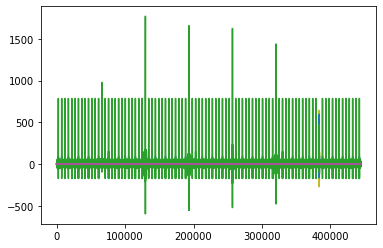

In [59]:
imbalance_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation="relu", input_shape=(15,15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [60]:
imbalance_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
imbalance_model.fit(X_train_imbalance, y_train_imbalance, epochs=5)

Epoch 1/5


2022-10-12 15:50:04.011995: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40032720 exceeds 10% of free system memory.
2022-10-12 15:50:04.028715: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40032720 exceeds 10% of free system memory.


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_6" (type Sequential).
    
    Input 0 of layer "conv2d_4" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 15)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 15), dtype=float64)
      • training=True
      • mask=None


# Classify Horizontal Misalignment

In [ ]:
horizontal_data_0_5mm_FFT = FFT(horizontal_data[horizontal_keys[0]])
horizontal_data_1_0mm_FFT = FFT(horizontal_data[horizontal_keys[1]])
horizontal_data_1_5mm_FFT = FFT(horizontal_data[horizontal_keys[2]])
horizontal_data_2_0mm_FFT = FFT(horizontal_data[horizontal_keys[3]])

horizontal_data_FFT = pd.concat([horizontal_data_0_5mm_FFT, horizontal_data_1_0mm_FFT, horizontal_data_1_5mm_FFT, horizontal_data_2_0mm_FFT], ignore_index=True )

In [ ]:
y_horizontal_data_0_5mm = pd.DataFrame(np.zeros(len(horizontal_data_0_5mm_FFT), dtype=int))
y_horizontal_data_1_0mm = pd.DataFrame(np.ones(len(horizontal_data_1_0mm_FFT), dtype=int))
y_horizontal_data_1_5mm = pd.DataFrame(np.full(len(horizontal_data_1_5mm_FFT), 2, dtype=int))
y_horizontal_data_2_0mm = pd.DataFrame(np.full(len(horizontal_data_2_0mm_FFT), 3, dtype=int))

y_horizontal = pd.concat([y_horizontal_data_0_5mm, y_horizontal_data_1_0mm, y_horizontal_data_1_5mm, y_horizontal_data_2_0mm], ignore_index=True)

In [ ]:
X_train_horizontal, X_test_horizontal, y_train_horizontal, y_test_horizontal = train_test_split(horizontal_data_FFT, y_horizontal, test_size=0.25, shuffle=True)

In [ ]:
horizontal_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation="relu", input_shape=(15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [ ]:
horizontal_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
horizontal_model.fit(X_train_horizontal, y_train_horizontal, epochs=5)

In [ ]:
horizontal_model.save('Mafaulda_app/models/horizontal_model.h5')

# Classify Vertical Misalignment

In [ ]:
vertical_data_0_51_FFT = FFT(vertical_data[vertical_keys[0]])
vertical_data_0_63_FFT = FFT(vertical_data[vertical_keys[1]])
vertical_data_1_27_FFT = FFT(vertical_data[vertical_keys[2]])
vertical_data_1_40_FFT = FFT(vertical_data[vertical_keys[3]])
vertical_data_1_78_FFT = FFT(vertical_data[vertical_keys[4]])
vertical_data_1_90_FFT = FFT(vertical_data[vertical_keys[5]])

vertical_data_FFT = pd.concat([vertical_data_0_51_FFT, vertical_data_0_63_FFT, vertical_data_1_27_FFT, vertical_data_1_40_FFT, vertical_data_1_78_FFT, vertical_data_1_90_FFT], ignore_index=True)

In [ ]:
y_vertical_data_0_51 = pd.DataFrame(np.zeros(len(vertical_data_0_51_FFT), dtype=int))
y_vertical_data_0_63 = pd.DataFrame(np.ones(len(vertical_data_0_63_FFT), dtype=int))
y_vertical_data_1_27 = pd.DataFrame(np.full(len(vertical_data_1_27_FFT), 2, dtype=int))
y_vertical_data_1_40 = pd.DataFrame(np.full(len(vertical_data_1_40_FFT), 3, dtype=int))
y_vertical_data_1_78 = pd.DataFrame(np.full(len(vertical_data_1_40_FFT), 4, dtype=int))
y_vertical_data_1_90 = pd.DataFrame(np.full(len(vertical_data_1_40_FFT), 5, dtype=int))

y_vertical = pd.concat([y_vertical_data_0_51, y_vertical_data_0_63, y_vertical_data_1_27, y_vertical_data_1_40, y_vertical_data_1_78, y_vertical_data_1_90], ignore_index=True)

In [ ]:
X_train_vertical, X_test_vertical, y_train_vertical, y_test_vertical = train_test_split(vertical_data_FFT, y_vertical, test_size=0.25, shuffle=True)

In [ ]:
vertical_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation="relu", input_shape=(15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [ ]:
vertical_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
vertical_model.fit(X_train_vertical, y_train_vertical, epochs=5)

In [ ]:
vertical_model.save('Mafaulda_app/models/vertical_model.h5')

# Classify Overhang Health Bearing

In [ ]:
overhang_data_ball_0g_FFT = FFT(overhang_data[overhang_keys[0]])
overhang_data_ball_6g_FFT = FFT(overhang_data[overhang_keys[1]])
overhang_data_ball_20g_FFT = FFT(overhang_data[overhang_keys[2]])
overhang_data_ball_35g_FFT = FFT(overhang_data[overhang_keys[3]])

overhang_data_cage_0g_FFT = FFT(overhang_data[overhang_keys[4]])
overhang_data_cage_6g_FFT = FFT(overhang_data[overhang_keys[5]])
overhang_data_cage_20g_FFT = FFT(overhang_data[overhang_keys[6]])
overhang_data_cage_35g_FFT = FFT(overhang_data[overhang_keys[7]])

overhang_data_outerRace_0g_FFT = FFT(overhang_data[overhang_keys[8]])
overhang_data_outerRace_6g_FFT = FFT(overhang_data[overhang_keys[9]])
overhang_data_outerRace_20g_FFT = FFT(overhang_data[overhang_keys[10]])
overhang_data_outerRace_35g_FFT = FFT(overhang_data[overhang_keys[11]])

overhang_data_FFT = pd.concat([overhang_data_ball_0g_FFT, overhang_data_ball_6g_FFT, overhang_data_ball_20g_FFT, overhang_data_ball_35g_FFT, overhang_data_cage_0g_FFT, overhang_data_cage_6g_FFT, overhang_data_cage_20g_FFT, overhang_data_cage_35g_FFT, overhang_data_outerRace_0g_FFT, overhang_data_outerRace_6g_FFT, overhang_data_outerRace_20g_FFT, overhang_data_outerRace_35g_FFT], ignore_index=True)

In [ ]:
y_overhang_data_ball_0g = pd.DataFrame(np.zeros(len(overhang_data_ball_0g_FFT), dtype=int))
y_overhang_data_ball_6g = pd.DataFrame(np.ones(len(overhang_data_ball_6g_FFT), dtype=int))
y_overhang_data_ball_20g = pd.DataFrame(np.full(len(overhang_data_ball_20g_FFT), 2, dtype=int))
y_overhang_data_ball_35g = pd.DataFrame(np.full(len(overhang_data_ball_35g_FFT), 3, dtype=int))
y_overhang_data_cage_0g = pd.DataFrame(np.zeros(len(overhang_data_cage_0g_FFT), dtype=int))
y_overhang_data_cage_6g = pd.DataFrame(np.ones(len(overhang_data_cage_6g_FFT), dtype=int)) 
y_overhang_data_cage_20g = pd.DataFrame(np.full(len(overhang_data_cage_20g_FFT), 2, dtype=int))
y_overhang_data_cage_35g = pd.DataFrame(np.full(len(overhang_data_cage_35g_FFT), 3, dtype=int))
y_overhang_data_outerRace_0g = pd.DataFrame(np.zeros(len(overhang_data_outerRace_0g_FFT), dtype=int))
y_overhang_data_outerRace_6g = pd.DataFrame(np.ones(len(overhang_data_outerRace_6g_FFT), dtype=int))
y_overhang_data_outerRace_20g = pd.DataFrame(np.full(len(overhang_data_outerRace_20g_FFT), 2, dtype=int))
y_overhang_data_outerRace_35g = pd.DataFrame(np.full(len(overhang_data_outerRace_35g_FFT), 3, dtype=int))

y_overhang = pd.concat([y_overhang_data_ball_0g, y_overhang_data_ball_6g, y_overhang_data_ball_20g, y_overhang_data_ball_35g, y_overhang_data_cage_0g, y_overhang_data_cage_6g, y_overhang_data_cage_20g, y_overhang_data_cage_35g, y_overhang_data_outerRace_0g, y_overhang_data_outerRace_6g, y_overhang_data_outerRace_20g, y_overhang_data_outerRace_35g], ignore_index=True)

In [ ]:
# y_overhang #60088
overhang_data_FFT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(overhang_data_FFT, y_overhang, test_size=0.25, shuffle=True)

In [ ]:
overhang_data_FFT

In [ ]:
overhang_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation="relu", input_shape=(15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [ ]:
overhang_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
overhang_model.fit(X_train, y_train, epochs=5)

In [ ]:
overhang_model.save('Mafaulda_app/models/overhang_model.h5')

# Classify Underhang Health Bearing

In [ ]:
underhang_data_ball_0g_FFT = FFT(underhang_data[underhang_keys[0]])
underhang_data_ball_6g_FFT = FFT(underhang_data[underhang_keys[1]])
underhang_data_ball_20g_FFT = FFT(underhang_data[underhang_keys[2]])
underhang_data_ball_35g_FFT = FFT(underhang_data[underhang_keys[3]])

underhang_data_cage_0g_FFT = FFT(underhang_data[underhang_keys[4]])
underhang_data_cage_6g_FFT = FFT(underhang_data[underhang_keys[5]])
underhang_data_cage_20g_FFT = FFT(underhang_data[underhang_keys[6]])
underhang_data_cage_35g_FFT = FFT(underhang_data[underhang_keys[7]])

underhang_data_outerRace_0g_FFT = FFT(underhang_data[underhang_keys[8]])
underhang_data_outerRace_6g_FFT = FFT(underhang_data[underhang_keys[9]])
underhang_data_outerRace_20g_FFT = FFT(underhang_data[underhang_keys[10]])
underhang_data_outerRace_35g_FFT = FFT(underhang_data[underhang_keys[11]])

underhang_data_FFT = pd.concat([underhang_data_ball_0g_FFT, underhang_data_ball_6g_FFT, underhang_data_ball_20g_FFT, underhang_data_ball_35g_FFT, underhang_data_cage_0g_FFT, underhang_data_cage_6g_FFT, underhang_data_cage_20g_FFT, underhang_data_cage_35g_FFT, underhang_data_outerRace_0g_FFT, underhang_data_outerRace_6g_FFT, underhang_data_outerRace_20g_FFT, underhang_data_outerRace_35g_FFT], ignore_index=True)

In [ ]:
y_underhang_data_ball_0g = pd.DataFrame(np.zeros(len(underhang_data_ball_0g_FFT), dtype=int))
y_underhang_data_ball_6g = pd.DataFrame(np.ones(len(underhang_data_ball_6g_FFT), dtype=int))
y_underhang_data_ball_20g = pd.DataFrame(np.full(len(underhang_data_ball_20g_FFT), 2, dtype=int))
y_underhang_data_ball_35g = pd.DataFrame(np.full(len(underhang_data_ball_35g_FFT), 3, dtype=int))
y_underhang_data_cage_0g = pd.DataFrame(np.zeros(len(underhang_data_cage_0g_FFT), dtype=int))
y_underhang_data_cage_6g = pd.DataFrame(np.ones(len(underhang_data_cage_6g_FFT), dtype=int)) 
y_underhang_data_cage_20g = pd.DataFrame(np.full(len(underhang_data_cage_20g_FFT), 2, dtype=int))
y_underhang_data_cage_35g = pd.DataFrame(np.full(len(underhang_data_cage_35g_FFT), 3, dtype=int))
y_underhang_data_outerRace_0g = pd.DataFrame(np.zeros(len(underhang_data_outerRace_0g_FFT), dtype=int))
y_underhang_data_outerRace_6g = pd.DataFrame(np.ones(len(underhang_data_outerRace_6g_FFT), dtype=int))
y_underhang_data_outerRace_20g = pd.DataFrame(np.full(len(underhang_data_outerRace_20g_FFT), 2, dtype=int))
y_underhang_data_outerRace_35g = pd.DataFrame(np.full(len(underhang_data_outerRace_35g_FFT), 3, dtype=int))

y_underhang = pd.concat([y_underhang_data_ball_0g, y_underhang_data_ball_6g, y_underhang_data_ball_20g, y_underhang_data_ball_35g, y_underhang_data_cage_0g, y_underhang_data_cage_6g, y_underhang_data_cage_20g, y_underhang_data_cage_35g, y_underhang_data_outerRace_0g, y_underhang_data_outerRace_6g, y_underhang_data_outerRace_20g, y_underhang_data_outerRace_35g], ignore_index=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(underhang_data_FFT, y_underhang, test_size=0.25, shuffle=True)

In [ ]:
underhang_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation="relu", input_shape=(15,1)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)])

In [ ]:
underhang_model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
underhang_model.fit(X_train, y_train, epochs=5)

In [ ]:
underhang_model.save('Mafaulda_app/models/underhang_model.h5')

# Final Classfication

In [ ]:
#Vou ter que ver como tratar parcialmente os dados para jogar na classificação geral para depois afunilar e aplicar nos modelos dos tipos de erros

def final_classification(x, y, index):
    responses = {0:'normal', 1:['imbalance', imbalance_model], 2:['horizontal', horizontal_model], 3:['vertical', vertical_model], 4:['overhang', overhang_model], 5:['underhang', underhang_model]}
    general_predict = fault_model.predict(x)
    general_predict = responses[np.argmax(general_predict[index], axis=0)][0]
    
    if predict == 'normal':
        print("Status predicted: " + predict)
    else:
        print("General status predicted: " + predict)
        
        

In [ ]:
final_classification(

# Rolar tabela

In [ ]:
def rolling_rows(data):
    data = np.array(data)
    roll_data = []
    
    for i in range(len(data)):
        roll_data.append(data[i-200])

    return pd.DataFrame(roll_data)

In [ ]:
test_imbalance = imbalance_data[imbalance_keys[0]]
test_imbalance

In [ ]:
result = rolling_rows(test_imbalance)
result[200:250]

# Application

# REST

In [ ]:
y_normal = pd.DataFrame(np.zeros(len(normal_reduced), dtype=int))

y_imbalance6 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[0]]), dtype=int))
y_imbalance10 = pd.DataFrame(np.full(len(imbalance_data[imbalance_keys[1]]), 2, dtype=int)) 
y_imbalance15 = pd.DataFrame(np.full(len(imbalance_data[imbalance_keys[2]]), 3, dtype=int)) 
y_imbalance20 = pd.DataFrame(np.full(len(imbalance_data[imbalance_keys[3]]), 4, dtype=int)) 
y_imbalance25 = pd.DataFrame(np.full(len(imbalance_data[imbalance_keys[4]]), 5, dtype=int)) 
y_imbalance30 = pd.DataFrame(np.full(len(imbalance_data[imbalance_keys[5]]), 6, dtype=int)) 
y_imbalance35 = pd.DataFrame(np.full(len(imbalance_data[imbalance_keys[6]]), 7, dtype=int))

y_horizontal_data_0_5mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[0]]), 8, dtype=int)) 
y_horizontal_data_1_0mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[1]]), 9, dtype=int)) 
y_horizontal_data_1_5mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[2]]), 10, dtype=int)) 
y_horizontal_data_2_0mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[3]]), 11, dtype=int))

y_vertical_data_0_51 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[0]]), 12, dtype=int))
y_vertical_data_0_63 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[1]]), 13, dtype=int))
y_vertical_data_1_27 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[2]]), 14, dtype=int))
y_vertical_data_1_40 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[3]]), 15, dtype=int))
y_vertical_data_1_78 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[4]]), 16, dtype=int))
y_vertical_data_1_90 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[5]]), 17, dtype=int))

y_total = pd.concat([y_normal, y_imbalance6, y_imbalance10, y_imbalance15, y_imbalance20, y_imbalance25, 
               y_imbalance30, y_imbalance35, y_horizontal_data_0_5mm, y_horizontal_data_1_0mm, y_horizontal_data_1_5mm,
               y_horizontal_data_2_0mm, y_vertical_data_0_51 ,y_vertical_data_0_63, y_vertical_data_1_27, y_vertical_data_1_40, 
               y_vertical_data_1_78, y_vertical_data_1_90], 
              ignore_index=True)
y_total

In [ ]:
y_normal = pd.DataFrame(np.zeros(len(normal_reduced), dtype=int))

y_imbalance6 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[0]]), dtype=int))
y_imbalance10 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[1]]), dtype=int)) 
y_imbalance15 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[2]]), dtype=int)) 
y_imbalance20 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[3]]), dtype=int)) 
y_imbalance25 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[4]]), dtype=int)) 
y_imbalance30 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[5]]), dtype=int)) 
y_imbalance35 = pd.DataFrame(np.ones(len(imbalance_data[imbalance_keys[6]]), dtype=int))

y_horizontal_data_0_5mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[0]]), 2, dtype=int)) 
y_horizontal_data_1_0mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[1]]), 2, dtype=int)) 
y_horizontal_data_1_5mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[2]]), 2, dtype=int)) 
y_horizontal_data_2_0mm = pd.DataFrame(np.full(len(horizontal_data[horizontal_keys[3]]), 2, dtype=int))

y_vertical_data_0_51 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[0]]), 3, dtype=int))
y_vertical_data_0_63 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[1]]), 3, dtype=int))
y_vertical_data_1_27 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[2]]), 3, dtype=int))
y_vertical_data_1_40 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[3]]), 3, dtype=int))
y_vertical_data_1_78 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[4]]), 3, dtype=int))
y_vertical_data_1_90 = pd.DataFrame(np.full(len(vertical_data[vertical_keys[5]]), 3, dtype=int))

y_total = pd.concat([y_normal, y_imbalance6, y_imbalance10, y_imbalance15, y_imbalance20, y_imbalance25, 
               y_imbalance30, y_imbalance35, y_horizontal_data_0_5mm, y_horizontal_data_1_0mm, y_horizontal_data_1_5mm,
               y_horizontal_data_2_0mm, y_vertical_data_0_51 ,y_vertical_data_0_63, y_vertical_data_1_27, y_vertical_data_1_40, 
               y_vertical_data_1_78, y_vertical_data_1_90], 
              ignore_index=True)
y_total

In [ ]:
total_data = pd.DataFrame(normal_data)

print("Imbalance Data")
for i in range(len(imbalance_keys)):
    itinerator = imbalance_data[imbalance_keys[i]]
    print(itinerator.shape)
    total_data = pd.concat([total_data, itinerator], ignore_index=True)
print("------------------")

print("Horizontal Data")
for i in range(len(horizontal_keys)):
    itinerator = horizontal_data[horizontal_keys[i]]
    print(itinerator.shape)
    total_data = pd.concat([total_data, itinerator], ignore_index=True)
print("------------------")

print("Vertical Data")
for i in range(len(vertical_keys)):
    itinerator = vertical_data[vertical_keys[i]]
    print(itinerator.shape)
    total_data = pd.concat([total_data, itinerator], ignore_index=True)
print("------------------")

In [ ]:
total_data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(total_data, y_total, test_size=0.25, shuffle=True)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
    tf.keras.layers.Dense(8, activation=tf.nn.softmax)])

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#The accuracy decreases because the model could assume 0 to hard inputs classification. Balanced data become classification harder
model.fit(X_train, y_train, epochs=5)

In [ ]:
zibs_model = load_model("Mafaulda_app/models/fault_model.h5")


In [ ]:
zibs_model.predict(X_test[0:1])

In [ ]:
value = np.array(X_test[0:1])

In [ ]:
value

In [ ]:
zibs = [0.35107426,  0.1212187 , -0.35445322, -0.10401338,  0.42226383,
         0.37491483, -1.74464073, -0.69076039, -4.35886673, -3.80692319,
        -0.33017811,  0.62848284,  0.65316731,  0.21307042,  0.21397822]

In [ ]:
zibs